# Exercise 2 - Multi-class text classification Problem

GOAL: Use Supervised Machine Learning Methods and NLP to build a model that classifies new incoming "user complains" into one of the product categories.
      Target variable: Product
      Feature: "Consumer complaint narrative"

EXERCISE: 
    - Preprocess the dataset 
        NB: please notice that the TfidVectorized will not run locally on the whole dataset. The exercise will be presented on a non-random subsample of 5000 rows
        NBB: Select a RANDOM subsample of your choice 
    - Use TF-IDF for Text Representation
    - Using the Naive Bayes implementation as a guidance, apply other classification models to the problem.
    - Evaluate all the models used and identify the best one (Models benchmarking and comparison examples are included in the code)
    

# Walkthrough

#### Data Exploration
     - cutting dataset
#### Data Cleaning
     - checking for class imbalances
#### Text Representation
    - TF-IDF
    - Finding terms correlations
#### Classifier Implementation (Naive Bayes)
#### Multiple Model Implementation 
#### Benchmarking and Evaluation

### DATA EXPLORATION

In [336]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os
import smart_open
import collections

from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import scipy.stats as stats # randint, uniform

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost

In [243]:
df = pd.read_csv('data/Consumer_Complaints.csv')
df.head()

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,12/31/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"Convergent Resources, Inc.",GA,NaN,NaN,NaN,Web,12/31/2018,Closed with explanation,Yes,NaN,3113161
1,12/31/2018,Vehicle loan or lease,Lease,Managing the loan or lease,Problem with fees charged,NaN,NaN,MERCEDES BENZ FINANCIAL SERVICES,CA,NaN,NaN,Other,Web,12/31/2018,In progress,Yes,NaN,3113131
2,12/31/2018,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,"BCA Financial Services, Inc.",FL,336XX,NaN,NaN,Web,12/31/2018,In progress,Yes,NaN,3113586
3,12/31/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"Commonwealth Financial Systems, Inc.",GA,NaN,NaN,NaN,Web,12/31/2018,Closed with explanation,Yes,NaN,3113440
4,12/31/2018,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,NaN,NaN,AES/PHEAA,OR,NaN,NaN,NaN,Web,12/31/2018,Closed with explanation,Yes,NaN,3113157


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189771 entries, 0 to 1189770
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1189771 non-null  object
 1   Product                       1189771 non-null  object
 2   Sub-product                   954605 non-null   object
 3   Issue                         1189771 non-null  object
 4   Sub-issue                     670648 non-null   object
 5   Consumer complaint narrative  354576 non-null   object
 6   Company public response       402196 non-null   object
 7   Company                       1189771 non-null  object
 8   State                         1173147 non-null  object
 9   ZIP code                      1091506 non-null  object
 10  Tags                          162567 non-null   object
 11  Consumer consent provided?    627943 non-null   object
 12  Submitted via                 1189771 non-

In [245]:
#Running the exercise on the first 5000 rows
df = df.head(5000)

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 5000 non-null   object
 1   Product                       5000 non-null   object
 2   Sub-product                   5000 non-null   object
 3   Issue                         5000 non-null   object
 4   Sub-issue                     4335 non-null   object
 5   Consumer complaint narrative  525 non-null    object
 6   Company public response       1887 non-null   object
 7   Company                       5000 non-null   object
 8   State                         4827 non-null   object
 9   ZIP code                      4243 non-null   object
 10  Tags                          640 non-null    object
 11  Consumer consent provided?    1369 non-null   object
 12  Submitted via                 5000 non-null   object
 13  Date sent to compa

### DATA CLEANING

In [337]:
#TO DO: Identify the target and the feature columns
target = pd.read_csv('data/train_target.csv', index_col = 0)
features = pd.read_csv('data/train_features.csv', index_col = 0)

In [338]:
set(target['Product'])

{'Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit card or prepaid card',
 'Credit reporting',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Mortgage',
 'Student loan',
 'Vehicle loan or lease'}

In [249]:
features.isna().sum()

Date received                       0
Consumer complaint narrative        0
Company public response         13295
Company                             0
State                             247
ZIP code                         5466
Tags                            19960
Consumer consent provided?          0
Submitted via                       0
Date sent to company                0
Company response to consumer        0
Timely response?                    0
Consumer disputed?              12549
Complaint ID                        0
dtype: int64

In [250]:
#TO DO: Clean the columns (removing missing values)
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words('english')

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = re.sub("xxxx", "", sentence)
    sentence = re.sub("xxx", "", sentence)
    sentence = re.sub("xx", "", sentence)
    sentence = re.sub("\s\s+", " ", sentence)
       
    # stemming of words (seems not to affect accuracy, but should make things faster
    porter = PorterStemmer()
    words = word_tokenize(sentence)
    sentence = " ".join([porter.stem(word) for word in words])
      
    sentence = sentence.split(" ")
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
    sentence = " ".join(sentence)
    
    return sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [251]:
features['Consumer complaint narrative'] = [clean_sentence(narrative) for narrative in features['Consumer complaint narrative']]

#### Checking for class imbalances
- TO DO: visualize the category frequency in the dataset 
NB: NO RESAMPLING METHOD IS IMPLEMENTED

KeyboardInterrupt: 

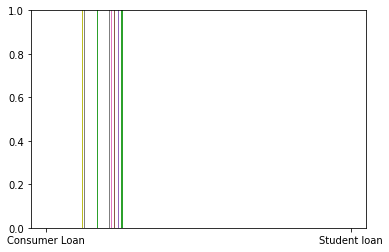

In [252]:
#plt.hist(target);

In [253]:
X_train, X_test, y_train, y_test = train_test_split(features['Consumer complaint narrative'], target, test_size=0.3, random_state=42)

#### Text Representation

Raw text cannot be used for classification purposes. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives

In [254]:

text_clf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf', MultinomialNB()),
])
text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print(classification_report(y_test, y_pred))

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.52      0.53      0.53       572
                                                 Checking or savings account       0.54      0.62      0.58       619
                                                               Consumer Loan       0.64      0.20      0.31       625
                                                                 Credit card       0.60      0.31      0.41       615
                                                 Credit card or prepaid card       0.47      0.66      0.55       590
                                                            Credit reporting       0.60      0.66      0.63       585
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.49      0.52       609
                                                       

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
text_clf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-4, random_state=42, # alpha = 1e-3 -> acc = 0.60; alpha = 1e-2 -> acc = 0.59;
                           max_iter=50, tol=None))
])
text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print(classification_report(y_test, y_pred))

Hmm, naive bayes was unexpectedly good here. Let's take a more structured approach:

In [258]:
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

In [290]:
for clf in classifiers:
    text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clf)
    ])
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    print("Accuracy of %s is %s"%(clf, acc))
    cm = confusion_matrix(y_test, predicted)
    print("Confusion Matrix of %s is %s"%(clf, cm))

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None) is 0.6431944444444444
Confusion Matrix of XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) is 0.6511111111111111
Confusion Matrix of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) is [[314 146   8  14  32   4   6   9  27   6   0   6]
 [185 338   3  10  24   1   8   3  36   5   2   4]
 [ 14   5 270  19   7  17  27  51   3  12   8 192]
 [ 25   5   6 317 166  22  21  30   8   2   0  13]
 [ 20  29  13 148 327   6  15   8  10   1   2  11]
 [  2   2  12  14   7 390 102  40   0   6   4   6]
 [  1   0  19  19  18 159 324  37   1   8  11  12]
 [  3   5  31  11   9  21  27 460   0   8   9  10]
 [ 31  44   1   4  17   1   2   5 4

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Accuracy of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) is 0.6022222222222222
Confusion Matrix of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf

XGBoost seems to be the most promising, let's try and tune it:

In [331]:
text_clf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf', svm.SVC())
])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(classification_report(y_test, predicted))

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.51      0.55      0.53       572
                                                 Checking or savings account       0.58      0.55      0.56       619
                                                               Consumer Loan       0.51      0.43      0.47       625
                                                                 Credit card       0.56      0.52      0.54       615
                                                 Credit card or prepaid card       0.52      0.55      0.54       590
                                                            Credit reporting       0.62      0.67      0.64       585
Credit reporting, credit repair services, or other personal consumer reports       0.57      0.53      0.55       609
                                                       

In [322]:
parameters_rand = {"vect__ngram_range"     : [(1, 1), (1, 2)],
                   "clf__C"                : stats.uniform(0.01, 100) ,
                   "clf__gamma"            : stats.uniform(.001, 100),
                  }

{'gamma': <scipy.stats._distn_infrastructure.rv_frozen at 0x258f056210>,
 'C': <scipy.stats._distn_infrastructure.rv_frozen at 0x258f056b90>}

In [323]:
rs_clf = RandomizedSearchCV(text_clf, parameters_rand, scoring = 'accuracy', cv=5, n_jobs=4, n_iter = 10, verbose = 2)

In [324]:
rs_clf = rs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 178.6min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 298.5min finished
/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [325]:
rs_clf.cv_results_

{'mean_fit_time': array([1906.22105751,  280.7250721 ,  281.57203155,  279.8934957 ,
        1903.10782743, 1854.80349374, 1893.22870293, 2012.73456564,
        1888.08466916, 1661.92716312]),
 'std_fit_time': array([ 53.56584146,   3.2956576 ,   2.2248588 ,   2.59276591,
         59.28149136,  35.24265441,  59.05916151,  54.29479797,
         44.99502111, 230.21414238]),
 'mean_score_time': array([1.57838244, 0.59305062, 0.61756864, 0.5684135 , 1.50517373,
        1.45609398, 1.51569309, 1.60115194, 1.5118979 , 1.1486877 ]),
 'std_score_time': array([0.05590416, 0.01361387, 0.0235396 , 0.01586316, 0.1472884 ,
        0.06810733, 0.2377514 , 0.16227825, 0.12581874, 0.23348799]),
 'param_clf__C': masked_array(data=[3.7961461977317987, 15.412962825062294,
                    4.83114965048842, 10.477825525054064,
                    57.53134683341422, 32.48496116540142,
                    98.68783794766074, 44.21618806180698,
                    3.3524521603362065, 7.474983691717364],
  

In [326]:
rs_clf.best_params_

{'clf__C': 3.7961461977317987,
 'clf__gamma': 9.780431188327436,
 'vect__ngram_range': (1, 2)}

In [328]:
y_pred_rs = rs_clf.predict(X_test)

In [329]:
test_features = pd.read_csv('data/test_features.csv', index_col = 0)
X_test2 = test_features['Consumer complaint narrative']
y_pred_test = rs_clf.predict(X_test2)
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test['Id'] = y_pred_test.index
y_pred_test['Product'] = y_pred_test[0]
y_pred_test = y_pred_test.drop(columns = 0)
y_pred_test.to_csv("data/consumer_pred3", index = False)

In [330]:
print(classification_report(y_test, y_pred_rs))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.48      0.48      0.48       572
                                                 Checking or savings account       0.54      0.51      0.53       619
                                                               Consumer Loan       0.44      0.40      0.42       625
                                                                 Credit card       0.51      0.53      0.52       615
                                                 Credit card or prepaid card       0.53      0.51      0.52       590
                                                            Credit reporting       0.55      0.63      0.59       585
Credit reporting, credit repair services, or other personal consumer reports       0.51      0.40      0.45       609
                                                       

In [332]:
test_features = pd.read_csv('data/test_features.csv', index_col = 0)

In [333]:
X_test2 = test_features['Consumer complaint narrative']
y_pred_test = rs_clf.predict(X_test2)

In [334]:
y_pred_test = pd.DataFrame(y_pred_test, columns = ['Product'])

In [ ]:
y_pred_test.head()

In [335]:
y_pred_test.to_csv("data/consumer_pred")

In [295]:
parameters_grid = {"vect__ngram_range"     : [(1, 1), (1, 2)],
                   "clf__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                   "clf__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                   "clf__min_child_weight" : [ 1, 3, 5, 7 ],
                   "clf__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                   "clf__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [296]:
gs_clf = GridSearchCV(text_clf, parameters_grid, scoring = 'accuracy', cv=5, n_jobs=-1, verbose = 2)

In [297]:
gs_clf = gs_clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
gs_clf.cv_results_

In [ ]:
predicted = gs_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, predicted))

## Let's try predicting using word2vec

In [ ]:

for i in range(len(X_train)):
    train_corpus = TaggedDocument(words = word_tokenize(X_train[i]), tags = y_train[i])

test_corpus = list(X_test)
    
    
d2v_model = Doc2Vec(vector_size = 5, 
                    window = 2, 
                    min_count = 2,
                    workers = -1,
                    epochs = 50)


In [ ]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [ ]:
counter = collections.Counter(ranks)
print(counter)

In [ ]:
# testing the model
# Pick a random document from the test corpus and infer a vector from the model
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(test_corpus[doc_id])
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

Let's try a neural network:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Nadam



In [ ]:
activation_func = 'softmax'
dropout_rate = 0.5
hidden_neurons = 500

model = Sequential()

model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(hidden_neurons, input_dim=input_dim, activation='activation_func'))
model.add(layers.LayerNormalization(axis=1 , center=True , scale=True))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(12, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999), 
              metrics=['categorical_crossentropy', 'accuracy', 'mse'])

In [ ]:
model.summary()

#### Finding terms correlation with Chi2 test

model_name
LinearSVC                 0.806520
LogisticRegression        0.679021
MultinomialNB             0.653663
RandomForestClassifier    0.537529
Name: accuracy, dtype: float64

#### Model Evaluation Example

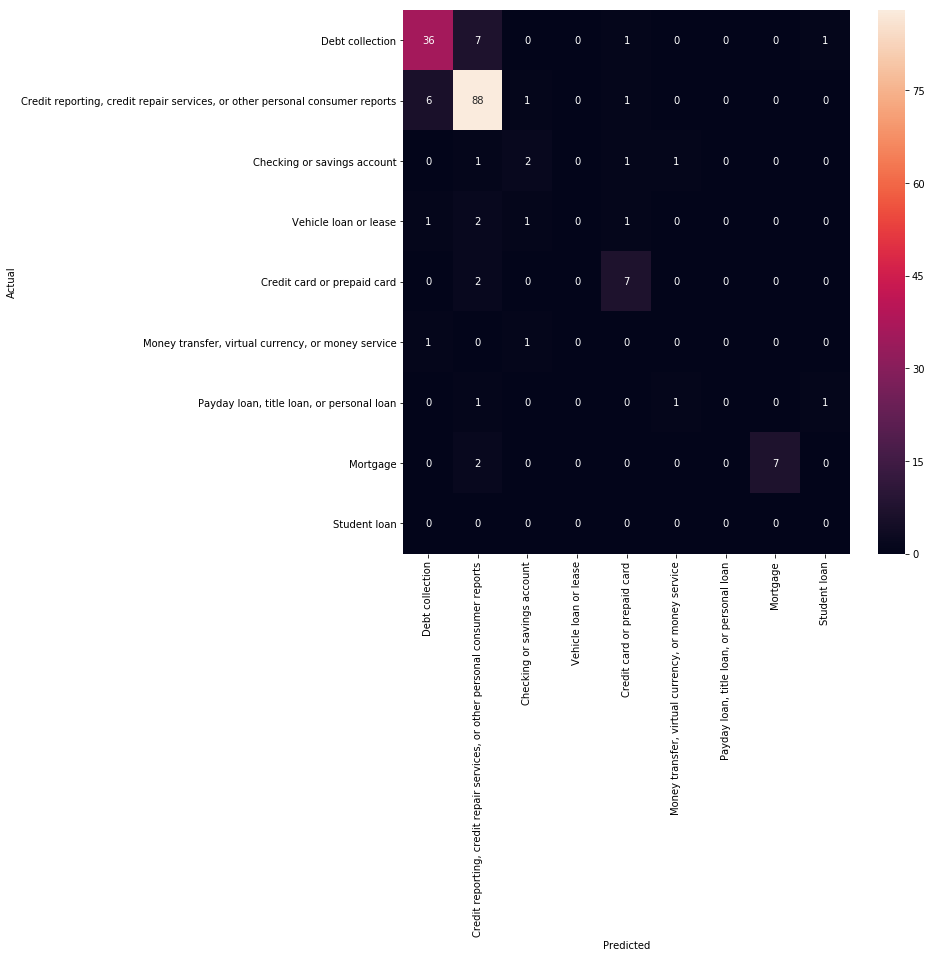

In [37]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Chi-squared test Correlation for model example

In [39]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'Checking or savings account':
  . Top unigrams:
       . checking
       . transactions
  . Top bigrams:
       . checking account
       . 400 00
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . store
  . Top bigrams:
       . 30 day
       . xxxx card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . transunion
       . experian
  . Top bigrams:
       . credit report
       . xxxx received
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . services xxxx
       . trying collect
# 'Money transfer, virtual currency, or money service':
  . Top unigrams:
       . transfer
       . money
  . Top bigrams:
       . 18 xxxx
       . days later
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . escrow
  . Top bigrams:
       . loan modification
       . freedom mortgage
# 'Payday loan, title loan, or personal loan':
  . Top unigrams:
       . loan
    

In [41]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.82      0.80      0.81        45
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.92      0.88        96
                                                 Checking or savings account       0.40      0.40      0.40         5
                                                       Vehicle loan or lease       0.00      0.00      0.00         5
                                                 Credit card or prepaid card       0.64      0.78      0.70         9
                          Money transfer, virtual currency, or money service       0.00      0.00      0.00         2
                                   Payday loan, title loan, or personal loan       0.00      0.00      0.00         3
                                                       

/home/clemente/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/clemente/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
